In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim


import os
import sys
cur_dir = os.path.dirname(os.path.abspath("__file__"))  # Gets the current notebook directory
src_dir = os.path.join(cur_dir, '../')  # Constructs the path to the 'src' directory
# Add the 'src' directory to sys.path
if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.constant import *
from tqdm.notebook import tqdm

from src.MyDataset import MyDataset
from src.TraPredModel import TraPredModel

In [16]:
lookback = 20
dir = '../data/PandasData/Original/'

ds = MyDataset(lookback=lookback)

In [23]:
def process_data(df_dir : str, target_freq : int = 10):
    df = pd.read_pickle(df_dir)
    f_per_sec = df.groupby('TimestampID').count().mean().mean()
    resample_ratio = int(f_per_sec/target_freq)
    df = df.iloc[::resample_ratio, :]
    # for origin
    df = df.drop(columns=['Confidence', 'Timestamp', 'TimestampID', 
                          'DatapointID', 'PID', 'SCN', 'U_X', 'U_Y', 'U_Z', 
                          'AGV_Z', 'User_Z', 'GazeOrigin_Z', 'User_Pitch', 'User_Yaw', 'User_Roll', 
                          'EyeTarget'], errors='ignore')
    return df

for file in os.listdir(dir):
    if file.endswith('.pkl'):
        df = process_data(dir+file)
        ds.read_data(df)

train, test = ds.split_data(frac=0.8, shuffle=True, batch_size=8)
feature_dim = ds.feature_dim

In [24]:
for i, (X, y) in enumerate(train):
    print(X.shape, y.shape)
    break

print(len(train), len(test))

torch.Size([8, 20, 13]) torch.Size([8, 20, 13])
31130 7783


In [25]:
model = TraPredModel(input_size=feature_dim, lookback=lookback)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


In [26]:
n_epochs = 1
eval_step = 100000
# model = TraPredModel(input_size=numeric_df.shape[1], lookback=lookback)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")
model.to(device)

train_all = len(train)

loss_all = []

for epoch in range(n_epochs):
    model.train()
    for step, (X_batch, y_batch) in tqdm(enumerate(train), total = train_all):
        X_batch = X_batch.float().to(device)
        y_batch = y_batch.float().to(device)

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch[:, :, :2])
        loss_all.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation
        if (epoch * train_all + step + 1) % eval_step == 0:
            print(f"Start testing")
            with torch.no_grad():
                model.eval()
                all_test = len(test)
                test_rmse_all = []
                for X_test_batch, y_test_batch in tqdm(test):
                    X_test_batch = X_test_batch.float().to(device)
                    y_test_batch = y_test_batch.float().to(device)
                    y_pred = model(X_test_batch)
                    test_rmse = loss_fn(y_pred, y_test_batch[:, :, :2])
                    if not torch.isnan(test_rmse):
                        test_rmse_all.append(test_rmse.item())

                print("Epoch %d: test RMSE %.4f" % (epoch, sum(test_rmse_all)/all_test))
            
            model.train()
        # break



Using cpu


  0%|          | 0/31130 [00:00<?, ?it/s]

In [52]:
loss_fn(y_pred, y_batch[:, :, :2])

tensor(9758858., grad_fn=<MseLossBackward0>)

In [53]:
y_pred

tensor([[[5526.6885, 5349.2661],
         [6903.9907, 6682.0483],
         [7115.0913, 6886.3257],
         [7144.1738, 6914.4683],
         [7148.1196, 6918.2856],
         [7148.6538, 6918.8027],
         [7148.7261, 6918.8726],
         [7148.7358, 6918.8823],
         [7148.7373, 6918.8838],
         [7148.7378, 6918.8843],
         [7148.7378, 6918.8843],
         [7148.7378, 6918.8843],
         [7148.7378, 6918.8843],
         [7148.7378, 6918.8843],
         [7148.7378, 6918.8843],
         [7148.7378, 6918.8843],
         [7148.7378, 6918.8843],
         [7148.7378, 6918.8843],
         [7148.7378, 6918.8843],
         [7148.7378, 6918.8843]],

        [[5526.6885, 5349.2661],
         [6903.9907, 6682.0483],
         [7115.0913, 6886.3257],
         [7144.1738, 6914.4683],
         [7148.1196, 6918.2856],
         [7148.6538, 6918.8027],
         [7148.7261, 6918.8726],
         [7148.7358, 6918.8823],
         [7148.7373, 6918.8838],
         [7148.7378, 6918.8843],
        

In [50]:
y_batch[:, :, :2]

tensor([[[13323.2607,  5839.9858],
         [13323.2607,  5839.9858],
         [13323.2607,  5839.9858],
         [13324.1748,  5836.4180],
         [13328.4189,  5826.6719],
         [13332.3330,  5812.8501],
         [13334.6670,  5800.7451],
         [13335.8506,  5792.7300],
         [13335.8838,  5792.4980],
         [13335.8838,  5792.4980],
         [13335.8838,  5792.4980],
         [13335.8838,  5792.4980],
         [13335.8838,  5792.4980],
         [13335.8838,  5792.4980],
         [13335.8838,  5792.4980],
         [13335.8838,  5792.4980],
         [13335.8838,  5792.4980],
         [13335.8838,  5792.4980],
         [13335.8838,  5792.4980],
         [13335.8838,  5792.4980]],

        [[ 5648.4888,  5896.2471],
         [ 5648.4888,  5896.2471],
         [ 5648.4888,  5896.2471],
         [ 5648.4888,  5896.2471],
         [ 5648.4888,  5896.2471],
         [ 5648.4888,  5896.2471],
         [ 5648.4888,  5896.2471],
         [ 5648.4888,  5896.2471],
         [ 5648.48

In [49]:
loss_np = np.array(loss_all)
np.sqrt(loss_np[:-10000]).mean()

2649.867344822799

In [43]:
y_batch[:, :, :2].shape

torch.Size([4, 20, 2])

In [41]:
a = torch.Tensor([[1, 2], [4,5]])
b = torch.Tensor([[1, 2], [0,0]])
loss_fn(a, b)

tensor(10.2500)

In [55]:
loss_all[:-10000]

[49137128.0,
 56255156.0,
 55522444.0,
 69357672.0,
 65483308.0,
 44713332.0,
 56677912.0,
 46821272.0,
 56401336.0,
 60903912.0,
 58100264.0,
 56132520.0,
 47943744.0,
 50699872.0,
 48245600.0,
 47894428.0,
 37865728.0,
 50824956.0,
 72268752.0,
 47589388.0,
 48781920.0,
 71826544.0,
 53995944.0,
 55524520.0,
 53299564.0,
 69889944.0,
 49806792.0,
 67323712.0,
 45887344.0,
 63624328.0,
 66014604.0,
 46429456.0,
 34355748.0,
 57499328.0,
 46125832.0,
 46581120.0,
 64347380.0,
 51382828.0,
 56788524.0,
 62787628.0,
 54333240.0,
 62008652.0,
 50592176.0,
 57797248.0,
 56727272.0,
 51494476.0,
 65409696.0,
 59125844.0,
 43791260.0,
 72847424.0,
 58565452.0,
 38501144.0,
 58222312.0,
 45588856.0,
 43400524.0,
 71734896.0,
 68829784.0,
 51176972.0,
 48887560.0,
 53305872.0,
 36399624.0,
 66049356.0,
 46379256.0,
 49196340.0,
 82130128.0,
 44295548.0,
 50922688.0,
 54988608.0,
 46552276.0,
 57735160.0,
 66124268.0,
 57344440.0,
 76601440.0,
 45889880.0,
 44021944.0,
 61674092.0,
 64187348.0,

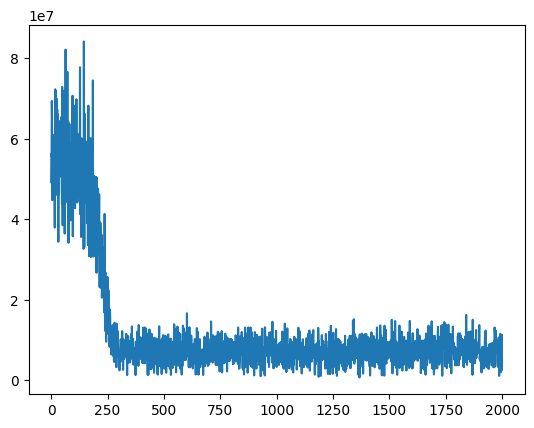

In [31]:
plt.plot(loss_all[:2000])